# Table of contents
* [Data preprocessing](#one)
* [Statistic about all dataset](#two)
* [XGBoost](#three)

In [1]:
import pandas as pd
import numpy as np

<a class="anchor" id="one"></a>

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
 <h1 style=font-size:40px><center> Data preprocessing </center></h1> 


#  1) Merging columns with samples data
Loading and merging files: <br>
-Pheno_SEX_AGE_ZAKODOWANE.xlsx  <-- Contains sex and age <br>
-Pheno_log_BMI_zakodowany.xlsx  <-- Contains logaritmic BMI <br>
-BioNinjaHack_obesity.ped  <-- Contains nitrogen bases

In [2]:
#Load files from paths
df_sex_age = pd.read_excel(r"raw_data\Pheno_SEX_AGE_ZAKODOWANE.xlsx")
df_log_bmi = pd.read_excel(r"raw_data\Pheno_log_BMI_zakodowany.xlsx")

#Create columns for dataframe
df_age = df_sex_age.AGE

#Merge columns 
df_merged = pd.merge(df_sex_age,df_log_bmi,on="IID")
df_merged = df_merged.drop(columns=['SEX_y'])
df_merged['index_bmi'] = df_merged['log_BMI'].apply(lambda x:2 if x>= 1.397940 else 1 )

#Load nitrogen bases for every person
pedtry = pd.read_table(r"raw_data\BioNinjaHack_obesity.ped",sep=" ",header=None)

#Rename columns
pedtry.rename(columns={5:'AAlog_BMI',0:'FID', 1:'IID',2:'M',3:'F',4:'Gender'},inplace=True)

#Repair invalid data and insert columns
pedtry['AAlog_BMI'] = df_merged['log_BMI']
pedtry.insert(4, "Age", df_age, True)
pedtry.insert(7,"Index_BMI",df_merged['index_bmi'],True)


pedtry.head(5)

,FID,IID,M,F,Age,Gender,AAlog_BMI,Index_BMI,6,7,...,654,655,656,657,658,659,660,661,662,663
0,3,1,0,0,64,2,1.410102,2.0,G,G,...,G,G,T,T,G,G,G,G,G,G
1,4,2,0,0,29,2,1.391112,1.0,G,G,...,A,G,T,T,G,G,G,G,G,G
2,5,3,0,0,64,1,1.381837,1.0,G,G,...,G,G,T,T,G,G,G,G,G,G
3,6,4,0,0,21,2,1.290702,1.0,A,G,...,G,G,T,T,G,G,G,G,G,G
4,7,5,0,0,38,2,1.494572,2.0,A,G,...,G,G,T,T,G,G,G,G,G,G


# 2) Creating KEY
Let's create Key column with pairs of nitrogen bases, that match will be checked with nitrogen bases in samples
<br><br>
Loading files: <br>
-BioNinjaHack_obesity.bim

In [3]:
#Create DF with snip name, nitrogen bases and KEY
snipy = pd.read_table(r"raw_data\BioNinjaHack_obesity.bim",sep="\t",header=None)
snipy['Key'] = snipy[4]+snipy[5]
snipy = snipy.drop(columns=[0,2,3])

#Create list with snips names
SnipNames = snipy[1].tolist()

snipy.head(5)

,1,4,5,Key
0,rs12620338,A,G,AG
1,rs7559271,G,A,GA
2,rs2234675,T,G,TG
3,rs6436302,T,C,TC
4,rs12053273,A,G,AG


# 3) Create pairs from nitrogen bases to compare them with KEY

In [4]:
#Merge bases in pairs to compare them
for i in range(0,658,2):
    pedtry[SnipNames[int(i/2)]] = pedtry[6+i]+pedtry[7+i]
    
    
colList = ['FID', 'IID','M','F','Gender', 'AAlog_BMI']
colList2 = list(pedtry.columns)
colList2 = colList2[666:]
colList.extend(colList2)
pedtry = pedtry[colList]

pedtry.head(5)

,FID,IID,M,F,Gender,AAlog_BMI,rs12620338,rs7559271,rs2234675,rs6436302,...,rs837550,rs2287072,rs112426189,rs3744374,rs12602590,rs11654604,rs200805689,rs117651561,rs79742527,rs143040759
0,3,1,0,0,2,1.410102,GG,GA,GG,TT,...,AA,AA,TG,AG,CC,GG,TT,GG,GG,GG
1,4,2,0,0,2,1.391112,GG,GG,GG,TC,...,GG,AA,GG,GG,CC,AG,TT,GG,GG,GG
2,5,3,0,0,1,1.381837,GG,AA,GG,CC,...,GA,AA,GG,AA,CC,GG,TT,GG,GG,GG
3,6,4,0,0,2,1.290702,AG,AA,GG,TC,...,GG,AA,GG,GG,CC,GG,TT,GG,GG,GG
4,7,5,0,0,2,1.494572,AG,AA,TG,TC,...,GA,AA,TG,AG,CC,GG,TT,GG,GG,GG


# 4) Compare key with nitrogen bases pairs in samples
If match = 1 , if not = 0

In [5]:
columns = SnipNames
listaSnipow = snipy.Key.tolist()

lookup = {key : (value,) for key, value in zip(columns, listaSnipow)}

columns = SnipNames
pedtry.loc[:, columns] = pedtry.loc[:, columns].isin((lookup))

pedtry.head(5)

,FID,IID,M,F,Gender,AAlog_BMI,rs12620338,rs7559271,rs2234675,rs6436302,...,rs837550,rs2287072,rs112426189,rs3744374,rs12602590,rs11654604,rs200805689,rs117651561,rs79742527,rs143040759
0,3,1,0,0,2,1.410102,False,True,False,False,...,False,False,True,True,False,False,False,False,False,False
1,4,2,0,0,2,1.391112,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,5,3,0,0,1,1.381837,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,6,4,0,0,2,1.290702,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,7,5,0,0,2,1.494572,True,False,True,True,...,True,False,True,True,False,False,False,False,False,False


### Change bool values to int values

In [6]:
pedtry = pedtry.applymap(lambda x:1 if x == True else x)
pedtry = pedtry.applymap(lambda x:0 if x == False else x)

pedtry = pedtry.where(pedtry.AAlog_BMI != -9).dropna()
pedtry['Gender'] = pedtry['Gender'] - 1
newColList = pedtry.columns.tolist()

pedtry.head(5)

,FID,IID,M,F,Gender,AAlog_BMI,rs12620338,rs7559271,rs2234675,rs6436302,...,rs837550,rs2287072,rs112426189,rs3744374,rs12602590,rs11654604,rs200805689,rs117651561,rs79742527,rs143040759
0,3.0,1.0,0.0,0.0,1.0,1.410102,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,0.0,0.0,1.0,1.391112,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5.0,3.0,0.0,0.0,0.0,1.381837,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,4.0,0.0,0.0,1.0,1.290702,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.0,5.0,0.0,0.0,1.0,1.494572,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5) Generate new features and drop useless one

In [7]:
BMI = 10**pedtry['AAlog_BMI']
pedtry.insert(6,'BMI',BMI,True)
pedtry.insert(4, "Age", df_age, True)

pedtry = pedtry.drop(columns=['FID',"IID",'M',"F"])

In [8]:
pedtry.head(5)

,Age,Gender,AAlog_BMI,BMI,rs12620338,rs7559271,rs2234675,rs6436302,rs12053273,rs1430657,...,rs837550,rs2287072,rs112426189,rs3744374,rs12602590,rs11654604,rs200805689,rs117651561,rs79742527,rs143040759
0,64,1.0,1.410102,25.71,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,1.0,1.391112,24.61,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,64,0.0,1.381837,24.09,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,1.0,1.290702,19.53,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38,1.0,1.494572,31.23,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
pedtry.to_csv("finalFile.csv", sep = ';')

<a class="anchor" id="two"></a>

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
 <h1 style=font-size:40px><center> Statistic about all dataset </center></h1> 


### 8 snips most corellated with obesity


328


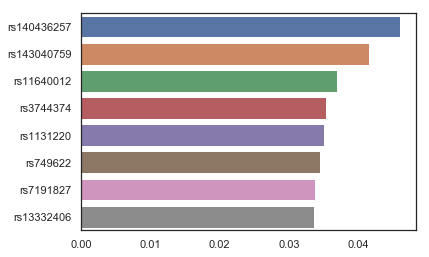

In [105]:
from pandas.plotting import scatter_matrix
import seaborn as sns

corr_matrix = pedtry.corr(method='pearson')
print(corr_matrix['AAlog_BMI'].size)
x = corr_matrix['AAlog_BMI'].sort_values(ascending=False)[3:11].index
y = corr_matrix['AAlog_BMI'].sort_values(ascending=False)[3:11].values

ax = sns.barplot(x=y, y=x)

### 8 snips most opposite-corellated with obesity


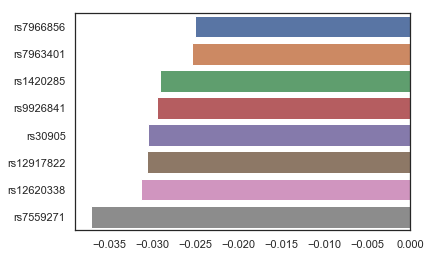

In [99]:
x = corr_matrix['AAlog_BMI'].sort_values(ascending=False)[-9:-1].index
y = corr_matrix['AAlog_BMI'].sort_values(ascending=False)[-9:-1].values

ax = sns.barplot(x=y, y=x)

### Plot heatmap BMI/Age

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 4032x432 with 0 Axes>

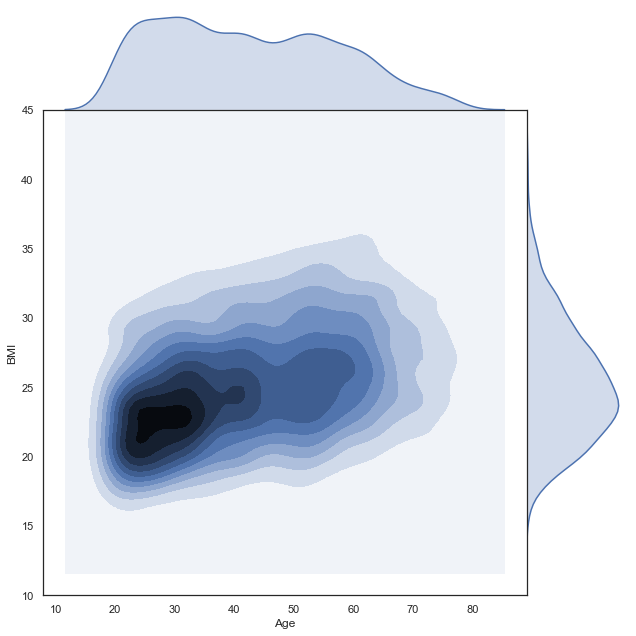

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(56, 6))
sns.set(style="white")
g = sns.jointplot(pedtry.Age, pedtry.BMI, kind="kde", height= 9 ,space=0, ylim=(10,45))

## Plot number of KeyMatch per single snip in all samples

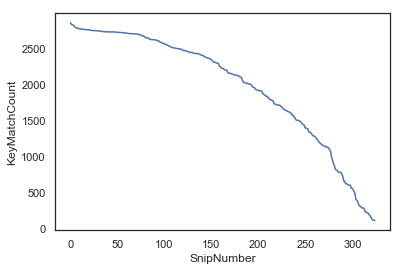

In [12]:
SumValues = pd.DataFrame(pedtry.sum(axis = 0, skipna = True).sort_values(ascending=False))
SumValues = SumValues.drop(['Age','AAlog_BMI','BMI','Gender'])

data = pd.DataFrame(data={'SnipNumber':np.linspace(0,324,num=324), 'KeyMatchCount':SumValues[0]})

sns.lineplot(x="SnipNumber", y="KeyMatchCount", data=data,sizes=(815,4))

## Plot mean BMI per year for male and female

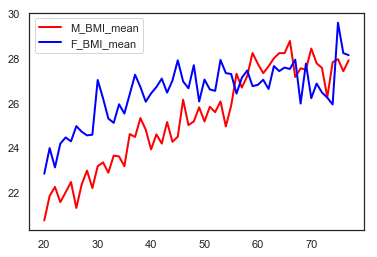

In [60]:
Male_BMI_mean = []
Age = []
Female_BMI_mean = []


for i in range(0,100):
    DataFrame = pedtry.loc[(pedtry['Age'] == i) & (pedtry['Gender'] == 1)]
    Male_BMI_mean.append(DataFrame.BMI.mean())
    Age.append(i)

    DataFrame = pedtry.loc[(pedtry['Age'] == i) & (pedtry['Gender'] == 0)]
    Female_BMI_mean.append(DataFrame.BMI.mean())

MaleBmiYearMean = pd.DataFrame({'Age': Age, 'M_BMI_mean': Male_BMI_mean, 'F_BMI_mean':Female_BMI_mean})


plt.plot( 'Age', 'M_BMI_mean', data=MaleBmiYearMean, marker='', color='red', linewidth=2)
plt.plot( 'Age', 'F_BMI_mean', data=MaleBmiYearMean, marker='', color='blue', linewidth=2)
plt.legend()


<a class="anchor" id="three"></a>

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
 <h1 style=font-size:40px><center> XGBoost </center></h1> 


In [ ]:
import numpy as np
import pandas as pd